<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# German News Articles

by Joel Akeret and Fabian Märki

## Summary
This is a short intro on how to access the *Ten Thousand German News Articles Dataset* for the *default project* (we still encourage you to work with your own dataset).

## Links
- [Ten Thousand German News Articles Dataset](https://tblock.github.io/10kGNAD/)

<a href="https://colab.research.google.com/github/markif/2021_HS_DAS_NLP_Notebooks/blob/master/XX_German_News_Article.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip install 'fhnw-nlp-utils>=0.1.3' pyarrow fastparquet

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe

import pandas as pd
import numpy as np

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


We propose to use the stratified train/test split proposed by the maintainer of the dataset.

In [2]:
file = "data/german_news_articles_original_train.parq"
download("https://drive.google.com/uc?id=1EuluVm0PX-akbh_EN-jZM2QbxXZ1uDeq", file)
data_train = load_dataframe(file)

file = "data/german_news_articles_original_test.parq"
download("https://drive.google.com/uc?id=1XI2yUaDaAy0PlD-ETiK8VMV_W1vOQ97n", file)
data_test = load_dataframe(file)

Get a first impression...

In [3]:
print(data_train.shape)
print(data_test.shape)

(9245, 2)
(1028, 2)


In [3]:
data_train["split"] = "train"
data_test["split"] = "test"

In [5]:
data_train.head(3)

,text_original,label,split
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,train
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,train
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,train


In [6]:
data_test.head(3)

,text_original,label,split
0,"Die Gewerkschaft GPA-djp lanciert den ""All-in-...",Wirtschaft,test
1,Franzosen verteidigen 2:1-Führung – Kritische ...,Sport,test
2,Neues Video von Designern macht im Netz die Ru...,Web,test


In [4]:
data_all = pd.concat([data_train, data_test])
data = data_train

In [48]:
data.head(3)

,text_clean
0,Jähriger fällt wohl bis Saisonende aus Wien R...
1,Erfundene Bilder zu Filmen die als verloren ge...
2,Der frischgekürte CEO Sundar Pichai setzt auf ...


Data analysieren. Verteilung der Label

<AxesSubplot:>

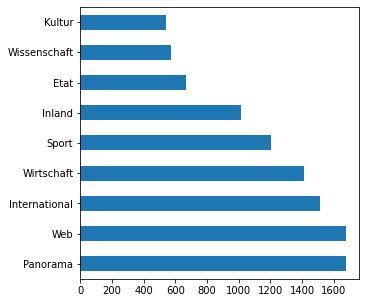

In [52]:
data_all['label'].value_counts().plot.barh(figsize=(5,5))

Es scheint keine 
- Null Zellen  
- HTML Zellen zu geben
- Zelle ohne Text


In [53]:
for col in data_all.columns:
    print(col, data[col].isnull().sum())

text_original 0
label 0
split 0


In [26]:
data[data["text_original"].str.contains("/>", na=False)]

,text_original,label,split


In [55]:
data_all[~data_all["text_original"].str.contains("[A-Za-z]", na=False)]

,text_original,label,split


In [5]:
!pip install fasttext
pretrained_model = "fasttext/supervised-models/lid.176.ftz"
download(url="https://dl.fbaipublicfiles.com/"+pretrained_model, path = pretrained_model)

import fasttext
model = fasttext.load_model(pretrained_model)

def predict_lang(text):
    """Predicts the language of a sentence

    Parameters
    ----------
    text : str
        The text to predict the language
        
    Returns
    -------
    str
        The predicted language (e.g. en, de, ...)
    """
        
    lang = model.predict(text)[0]
    return str(lang)[11:13]

def predict_lang_df(df, field_read="text", field_write="lang"):
    """Predicts the language of a column of text by calling predict_lang (primarily meant for parallel processing)

    Parameters
    ----------
    df : dataframe
        The dataframe
    field_read : str
        The column name to read from (default is text)
    field_write : str
        The column name to write to (default is lang)
        
    Returns
    -------
    dataframe
        The dataframe with the predicted language
    """
    
    # do not grow the dataframe directly - see https://stackoverflow.com/a/56746204
    series = df[field_read].map(
        lambda x: predict_lang(x)
    )
    
    return series.to_frame(field_write)

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [56]:
predict_lang_df(data_all, 'text_original').value_counts()

lang
de      10273
dtype: int64

In [6]:
%%time
from fhnw.nlp.utils.text import clean_text_df

data_all = parallelize_dataframe(data_all, clean_text_df, field_read="text_original", field_write="text_clean")

CPU times: user 755 ms, sys: 979 ms, total: 1.73 s
Wall time: 1.08 s


In [7]:
data_all.head(20)

,text_original,label,split,text_clean
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,train,Jähriger fällt wohl bis Saisonende aus Wien R...
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,train,Erfundene Bilder zu Filmen die als verloren ge...
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,train,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",Wirtschaft,train,Putin Einigung dass wir Menge auf Niveau von J...
4,Estland sieht den künftigen österreichischen P...,Inland,train,Estland sieht den künftigen österreichischen P...
5,Der Welser Stempelhersteller verbreitert sich ...,Wirtschaft,train,Der Welser Stempelhersteller verbreitert sich ...
6,Traditionsklub setzt sich gegen den FC Utrecht...,Sport,train,Traditionsklub setzt sich gegen den FC Utrecht...
7,Finanzausschuss tagte Montag: Konfliktthemen S...,Etat,train,Finanzausschuss tagte Montag Konfliktthemen St...
8,Militär setzt Offensive an Grenze zu Afghanist...,International,train,Militär setzt Offensive an Grenze zu Afghanist...
9,Abschiedstournee für Guardiola beginnt beim HS...,Sport,train,Abschiedstournee für Guardiola beginnt beim HS...


In [87]:
save_dataframe(data_all, "data/german_news_articles_original_train_and_test.parq")

In [8]:
!pip install 'spacy>=3.0.5'
!pip install nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import spacy
!python3 -m spacy download de_core_news_lg

nlp = spacy.load("de_core_news_lg")

import nltk
nltk.download('punkt')
nltk.download('stopwords')

stemmer = SnowballStemmer("german")
stopwords = set(stopwords.words("german"))
#stopwords = set(nlp.Defaults.stop_words)
empty_stopwords = set()

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_lg')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
%%time
from fhnw.nlp.utils.normalize import normalize_df

data_all = parallelize_dataframe(data_all, normalize_df, stopwords=stopwords, field_read="text_clean", field_write="token_clean", 
            stemmer=None, lemmanizer=None, lemma_with_ner=False)
data_all

CPU times: user 864 ms, sys: 867 ms, total: 1.73 s
Wall time: 8.37 s


,text_original,label,split,text_clean,token_clean
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,train,Jähriger fällt wohl bis Saisonende aus Wien R...,"[jähriger, fällt, wohl, saisonende, wien, rapi..."
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,train,Erfundene Bilder zu Filmen die als verloren ge...,"[erfundene, bilder, filmen, verloren, gelten, ..."
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,train,Der frischgekürte CEO Sundar Pichai setzt auf ...,"[frischgekürte, ceo, sundar, pichai, setzt, um..."
3,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",Wirtschaft,train,Putin Einigung dass wir Menge auf Niveau von J...,"[putin, einigung, menge, niveau, jänner, halte..."
4,Estland sieht den künftigen österreichischen P...,Inland,train,Estland sieht den künftigen österreichischen P...,"[estland, sieht, künftigen, österreichischen, ..."
...,...,...,...,...,...
1023,"Programm ""Ebay Plus"" soll Ende September start...",Web,test,Programm Ebay Plus soll Ende September starten...,"[programm, ebay, plus, ende, september, starte..."
1024,"Fehlerhafte Bilanz 2013, Partei will berufen –...",Inland,test,Fehlerhafte Bilanz Partei will berufen Keine S...,"[fehlerhafte, bilanz, partei, berufen, strafe,..."
1025,Als erster Olympia-Champion auch Hawaii-Sieger...,Sport,test,Als erster Olympia Champion auch Hawaii Sieger...,"[erster, olympia, champion, hawaii, sieger, ni..."
1026,Der Außenseiter aus Denver gewinnt die 50. Sup...,Sport,test,Der Außenseiter aus Denver gewinnt die Super B...,"[außenseiter, denver, gewinnt, super, bowl, ca..."


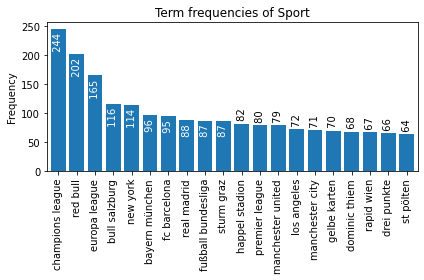

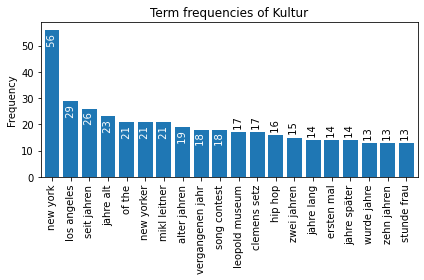

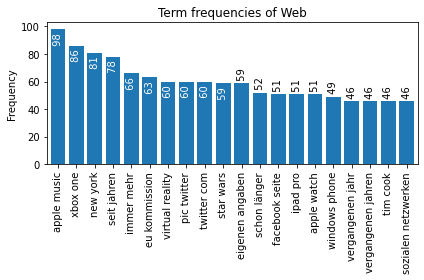

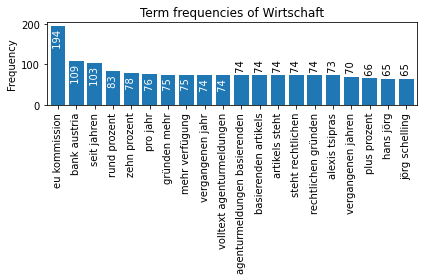

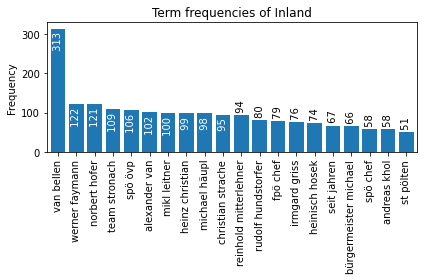

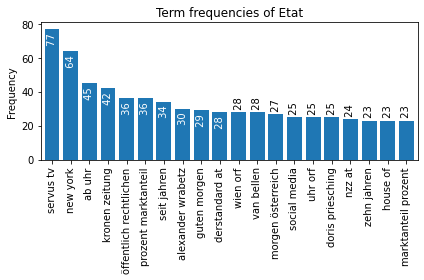

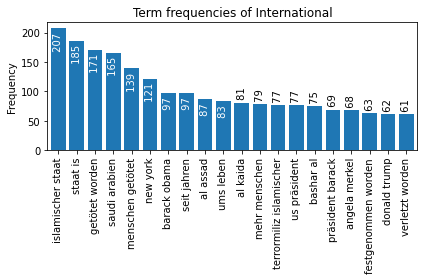

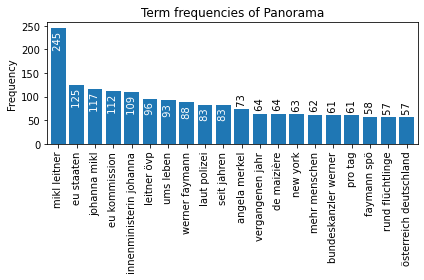

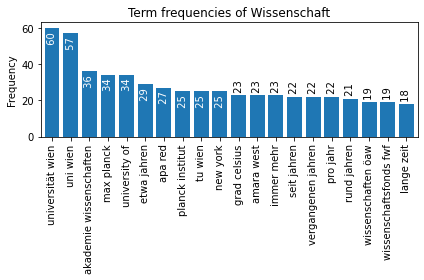

CPU times: user 3.61 s, sys: 1.85 s, total: 5.46 s
Wall time: 3.32 s


In [106]:
%%time
from fhnw.nlp.utils.text import create_ngram_counts
from fhnw.nlp.utils.ploting import plot_ngram_counts

for row, label in enumerate(data_all["label"].unique()):
    ngrams_1 = create_ngram_counts(data_all.loc[(data["label"] == label)], 1, field_read='token_clean')
    ngrams_2 = create_ngram_counts(data_all.loc[(data["label"] == label)], 2, field_read='token_clean')
    
    # plot_ngram_counts(ngrams_1, 20, "Term frequencies of "+label)
    plot_ngram_counts(ngrams_2, 20, "Term frequencies of "+label)


In [9]:
stopwords.add("millionen")
stopwords.add("milliarden")
stopwords.add("euro")
stopwords.add("dollar")
stopwords.add("mio")
stopwords.add("mrd")

In [13]:
data_all = data_all.drop(columns=['token_clean'], errors='ignore')
data_all = parallelize_dataframe(data_all, normalize_df, stopwords=stopwords, field_read="text_clean", field_write="token_clean", 
            stemmer=None, lemmanizer=None, lemma_with_ner=False)
data_all

,text_original,label,split,text_clean,token_clean
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,train,Jähriger fällt wohl bis Saisonende aus Wien R...,"[jähriger, fällt, wohl, saisonende, wien, rapi..."
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,train,Erfundene Bilder zu Filmen die als verloren ge...,"[erfundene, bilder, filmen, verloren, gelten, ..."
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,train,Der frischgekürte CEO Sundar Pichai setzt auf ...,"[frischgekürte, ceo, sundar, pichai, setzt, um..."
3,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",Wirtschaft,train,Putin Einigung dass wir Menge auf Niveau von J...,"[putin, einigung, menge, niveau, jänner, halte..."
4,Estland sieht den künftigen österreichischen P...,Inland,train,Estland sieht den künftigen österreichischen P...,"[estland, sieht, künftigen, österreichischen, ..."
...,...,...,...,...,...
1023,"Programm ""Ebay Plus"" soll Ende September start...",Web,test,Programm Ebay Plus soll Ende September starten...,"[programm, ebay, plus, ende, september, starte..."
1024,"Fehlerhafte Bilanz 2013, Partei will berufen –...",Inland,test,Fehlerhafte Bilanz Partei will berufen Keine S...,"[fehlerhafte, bilanz, partei, berufen, strafe,..."
1025,Als erster Olympia-Champion auch Hawaii-Sieger...,Sport,test,Als erster Olympia Champion auch Hawaii Sieger...,"[erster, olympia, champion, hawaii, sieger, ni..."
1026,Der Außenseiter aus Denver gewinnt die 50. Sup...,Sport,test,Der Außenseiter aus Denver gewinnt die Super B...,"[außenseiter, denver, gewinnt, super, bowl, ca..."


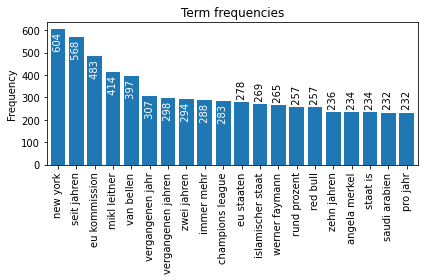

CPU times: user 1.48 s, sys: 164 ms, total: 1.65 s
Wall time: 1.51 s


In [107]:
%%time
from fhnw.nlp.utils.text import create_ngram_counts
from fhnw.nlp.utils.ploting import plot_ngram_counts

ngrams = create_ngram_counts(data_all,  field_read='token_clean')
plot_ngram_counts(ngrams, 20, "Term frequencies")
    


In [15]:
%%time
from fhnw.nlp.utils.normalize import normalize_df 

data_all = data_all.drop(columns=["token_lemma", 'token_stem', 'token_clean_stopwords'], errors='ignore')
#data_all = parallelize_dataframe(data_all, normalize_df, field_read="token_clean", field_write="token_lemma", stopwords=stopwords, stemmer=None, lemmanizer=nlp, lemma_with_ner=False, n_cores=12)
data_all = parallelize_dataframe(data_all, normalize_df, field_read="token_clean", field_write="token_stem", stopwords=stopwords, stemmer=stemmer, lemmanizer=None, lemma_with_ner=False, n_cores=12)
data_all = parallelize_dataframe(data_all, normalize_df, field_read="token_clean", field_write="token_clean_stopwords", stopwords=stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False, n_cores=12)

CPU times: user 12.7 s, sys: 867 ms, total: 13.5 s
Wall time: 15.8 s


In [17]:
%%time
save_dataframe(data_all, "data/german_news_articles_original_train_and_test_tokenized.parq")
data_all

CPU times: user 7.51 s, sys: 85.2 ms, total: 7.59 s
Wall time: 7.59 s


,text_original,label,split,text_clean,token_clean,token_stem,token_clean_stopwords
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,train,Jähriger fällt wohl bis Saisonende aus Wien R...,"[jähriger, fällt, wohl, saisonende, wien, rapi...","[jahrig, fallt, wohl, saison, wien, rapid, woh...","[jähriger, fällt, wohl, saisonende, wien, rapi..."
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,train,Erfundene Bilder zu Filmen die als verloren ge...,"[erfundene, bilder, filmen, verloren, gelten, ...","[erfund, bild, film, verlor, gelt, the, forbid...","[erfundene, bilder, filmen, verloren, gelten, ..."
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,train,Der frischgekürte CEO Sundar Pichai setzt auf ...,"[frischgekürte, ceo, sundar, pichai, setzt, um...","[frischgekurt, ceo, sundar, pichai, setzt, umg...","[frischgekürte, ceo, sundar, pichai, setzt, um..."
3,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",Wirtschaft,train,Putin Einigung dass wir Menge auf Niveau von J...,"[putin, einigung, menge, niveau, jänner, halte...","[putin, einig, meng, niveau, jann, halt, moska...","[putin, einigung, menge, niveau, jänner, halte..."
4,Estland sieht den künftigen österreichischen P...,Inland,train,Estland sieht den künftigen österreichischen P...,"[estland, sieht, künftigen, österreichischen, ...","[estland, sieht, kunftig, osterreich, prasiden...","[estland, sieht, künftigen, österreichischen, ..."
...,...,...,...,...,...,...,...
1023,"Programm ""Ebay Plus"" soll Ende September start...",Web,test,Programm Ebay Plus soll Ende September starten...,"[programm, ebay, plus, ende, september, starte...","[programm, ebay, plus, end, septemb, start, de...","[programm, ebay, plus, ende, september, starte..."
1024,"Fehlerhafte Bilanz 2013, Partei will berufen –...",Inland,test,Fehlerhafte Bilanz Partei will berufen Keine S...,"[fehlerhafte, bilanz, partei, berufen, strafe,...","[fehlerhaft, bilanz, partei, beruf, straf, weg...","[fehlerhafte, bilanz, partei, berufen, strafe,..."
1025,Als erster Olympia-Champion auch Hawaii-Sieger...,Sport,test,Als erster Olympia Champion auch Hawaii Sieger...,"[erster, olympia, champion, hawaii, sieger, ni...","[erst, olympia, champion, hawaii, sieg, nieder...","[erster, olympia, champion, hawaii, sieger, ni..."
1026,Der Außenseiter aus Denver gewinnt die 50. Sup...,Sport,test,Der Außenseiter aus Denver gewinnt die Super B...,"[außenseiter, denver, gewinnt, super, bowl, ca...","[aussenseit, denv, gewinnt, sup, bowl, carolin...","[außenseiter, denver, gewinnt, super, bowl, ca..."
